<a href="https://colab.research.google.com/github/freedaya/time-series-forecasting/blob/main/Fayzan_Rizky_Hidayat_DS39_DayEC7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import lightgbm as lgb
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')
plt.style.use("seaborn-v0_8")


#Data Exploration & Data Cleaning

In [124]:
df01 = pd.read_csv("/content/sales_data_january_2019.csv")
df02 = pd.read_csv("/content/sales_data_february_2019.csv")
df03 = pd.read_csv("/content/sales_data_march_2019.csv")
df04 = pd.read_csv("/content/sales_data_april_2019.csv")
df05 = pd.read_csv("/content/sales_data_may_2019.csv")
df06 = pd.read_csv("/content/sales_data_june_2019.csv")
df07 = pd.read_csv("/content/sales_data_july_2019.csv")
df08 = pd.read_csv("/content/sales_data_august_2019.csv")
df09 = pd.read_csv("/content/sales_data_september_2019.csv")
df10 = pd.read_csv("/content/sales_data_october_2019.csv")
df11 = pd.read_csv("/content/sales_data_november_2019.csv")
df12 = pd.read_csv("/content/sales_data_december_2019.csv")

In [125]:
df_list = [df01, df02, df03, df04, df05, df06,
           df07, df08, df09, df10, df11, df12]

for i, Df in enumerate(df_list, start=1):
    print(f"\n============================================= DataFrame df{i} =============================================")

    # 1. Check every column names
    print("Columns:")
    print(Df.columns.tolist())

    # 2. Check duplicate rows in every df
    print("\nDuplicate rows:")
    print(Df.duplicated().sum())

    # 3. Check null values in every df
    print("\nTotal null values:")
    print(Df.isnull().sum().sum())

    # 4. Shows null values per column
    null_cols = Df.isnull().sum()
    null_cols = null_cols[null_cols > 0]

    print("\nNull values per column:")
    print(null_cols if not null_cols.empty else "No null values")



============================================= DataFrame df1 =============================================
Columns:
['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', 'Purchase Address']

Duplicate rows:
50

Total null values:
156

Null values per column:
Order ID            26
Product             26
Quantity Ordered    26
Price Each          26
Order Date          26
Purchase Address    26
dtype: int64

============================================= DataFrame df2 =============================================
Columns:
['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date', 'Purchase Address']

Duplicate rows:
66

Total null values:
192

Null values per column:
Order ID            32
Product             32
Quantity Ordered    32
Price Each          32
Order Date          32
Purchase Address    32
dtype: int64

============================================= DataFrame df3 =============================================
Columns:
['Order ID', 'Product', 'Qua

In [126]:
df_list = [df01, df02, df03, df04, df05, df06,
           df07, df08, df09, df10, df11, df12]

df = pd.concat(df_list, ignore_index=True)

In [127]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,141234,iPhone,1,700,01/22/19 21:25,"944 Walnut St, Boston, MA 02215"
1,141235,Lightning Charging Cable,1,14.95,01/28/19 14:15,"185 Maple St, Portland, OR 97035"
2,141236,Wired Headphones,2,11.99,01/17/19 13:33,"538 Adams St, San Francisco, CA 94016"
3,141237,27in FHD Monitor,1,149.99,01/05/19 20:33,"738 10th St, Los Angeles, CA 90001"
4,141238,Wired Headphones,1,11.99,01/25/19 11:59,"387 10th St, Austin, TX 73301"


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186850 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 8.6+ MB


check duplicates then drop them

In [129]:
df.duplicated().sum()

np.int64(1162)

In [130]:
df.drop_duplicates(inplace=True)

Check missing values then drop them

In [131]:
df[df.isnull().any(axis=1)]


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
664,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
df.dropna(inplace=True)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185687 entries, 0 to 186849
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          185687 non-null  object
 1   Product           185687 non-null  object
 2   Quantity Ordered  185687 non-null  object
 3   Price Each        185687 non-null  object
 4   Order Date        185687 non-null  object
 5   Purchase Address  185687 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


Converting data types

In [134]:
df['Order Date'] = pd.to_datetime(
    df['Order Date'],
    format='%m/%d/%y %H:%M',
    errors='coerce')
df['Quantity Ordered'] = pd.to_numeric(df['Quantity Ordered'], errors='coerce')
df['Price Each'] = pd.to_numeric(df['Price Each'], errors='coerce')


Date type data feature engineering


In [135]:
df['Date'] = df['Order Date'].dt.date
df['Month'] = df['Order Date'].dt.to_period('M').astype(str)
df['Week'] = df['Order Date'].dt.to_period('W').astype(str)
df['hour'] = df['Order Date'].dt.hour
df['minute'] = df['Order Date'].dt.minute

df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Date,Month,Week,hour,minute
0,141234,iPhone,1.0,700.00,2019-01-22 21:25:00,"944 Walnut St, Boston, MA 02215",2019-01-22,2019-01,2019-01-21/2019-01-27,21.0,25.0
1,141235,Lightning Charging Cable,1.0,14.95,2019-01-28 14:15:00,"185 Maple St, Portland, OR 97035",2019-01-28,2019-01,2019-01-28/2019-02-03,14.0,15.0
2,141236,Wired Headphones,2.0,11.99,2019-01-17 13:33:00,"538 Adams St, San Francisco, CA 94016",2019-01-17,2019-01,2019-01-14/2019-01-20,13.0,33.0
3,141237,27in FHD Monitor,1.0,149.99,2019-01-05 20:33:00,"738 10th St, Los Angeles, CA 90001",2019-01-05,2019-01,2018-12-31/2019-01-06,20.0,33.0
4,141238,Wired Headphones,1.0,11.99,2019-01-25 11:59:00,"387 10th St, Austin, TX 73301",2019-01-25,2019-01,2019-01-21/2019-01-27,11.0,59.0


Check which row has one NaT after data type changes

In [136]:
df[df.isnull().any(axis=1)]


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Date,Month,Week,hour,minute
1073,Order ID,Product,NaN,NaN,NaT,Purchase Address,NaT,NaT,NaT,NaN,NaN


In [137]:
df.dropna(inplace=True)

setting order date as index and add more features

In [138]:
df.set_index('Order Date', inplace=True) # menjadikan kolom order date sebagai index

In [139]:
df['dayofweek'] = df.index.dayofweek
df['dayofyear'] = df.index.dayofyear
df['weekofyear'] = df.index.isocalendar().week.astype(int)
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Purchase Address,Date,Month,Week,hour,minute,dayofweek,dayofyear,weekofyear,is_weekend
Order Date,,,,,,,,,,,,,,
2019-01-22 21:25:00,141234,iPhone,1.0,700.00,"944 Walnut St, Boston, MA 02215",2019-01-22,2019-01,2019-01-21/2019-01-27,21.0,25.0,1,22,4,0
2019-01-28 14:15:00,141235,Lightning Charging Cable,1.0,14.95,"185 Maple St, Portland, OR 97035",2019-01-28,2019-01,2019-01-28/2019-02-03,14.0,15.0,0,28,5,0
2019-01-17 13:33:00,141236,Wired Headphones,2.0,11.99,"538 Adams St, San Francisco, CA 94016",2019-01-17,2019-01,2019-01-14/2019-01-20,13.0,33.0,3,17,3,0
2019-01-05 20:33:00,141237,27in FHD Monitor,1.0,149.99,"738 10th St, Los Angeles, CA 90001",2019-01-05,2019-01,2018-12-31/2019-01-06,20.0,33.0,5,5,1,1
2019-01-25 11:59:00,141238,Wired Headphones,1.0,11.99,"387 10th St, Austin, TX 73301",2019-01-25,2019-01,2019-01-21/2019-01-27,11.0,59.0,4,25,4,0


Check duplicated again

In [140]:
df.duplicated().sum()

np.int64(0)

In [141]:
df['Revenue'] = df['Quantity Ordered'] * df['Price Each']

#Q1. Calculate the total revenue, the number of orders, and the total quantity of items sold throughout 2019. In addition, calculate the average number of items purchased per transaction and the average spending per transaction.

In [142]:
total_revenue = df['Revenue'].sum()
total_orders = df['Order ID'].nunique()
total_items = df['Quantity Ordered'].sum()

avg_items_per_order = total_items / total_orders
avg_spending_per_order = total_revenue / total_orders
summary_df = pd.DataFrame({
    'Total Revenue': [total_revenue],
    'Total Orders': [total_orders],
    'Total Items Sold': [total_items],
    'Avg Items per Order': [avg_items_per_order],
    'Avg Spending per Order': [avg_spending_per_order]
})
summary_df


,Total Revenue,Total Orders,Total Items Sold,Avg Items per Order,Avg Spending per Order
0,34465537.94,178437,208812.0,1.170228,193.152418


#Q4. The marketing team wants to know which products were purchased most frequently over the past year. They plan to try bundling these top products to increase sales. Identify the top 10 products that generated the highest revenue in the last 3 months and determine which products can be bundled based on the analysis.

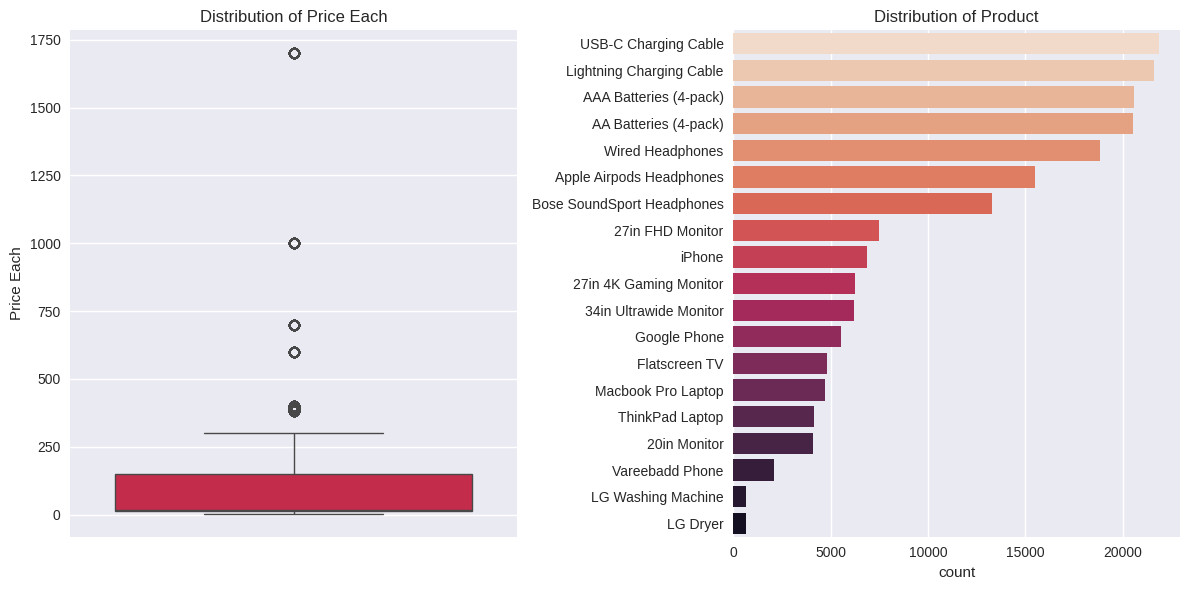

In [143]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(df['Price Each'].dropna(),ax=axes[0], color='crimson')
axes[0].set_title(f'Distribution of Price Each')

sns.countplot(y=df['Product'],ax=axes[1],palette='rocket_r', order = df['Product'].value_counts().index)
axes[1].set_title(f'Distribution of Product')
axes[1].set_ylabel(None)

plt.tight_layout()
plt.show()





The boxplot of Price Each shows a highly skewed distribution but this behavior is expected and considered normal in e-commerce transaction data.

USB-C Charging Cable and Lightning Charging Cable are the most frequently purchased products (based on the number of transactions not by quantities sold).

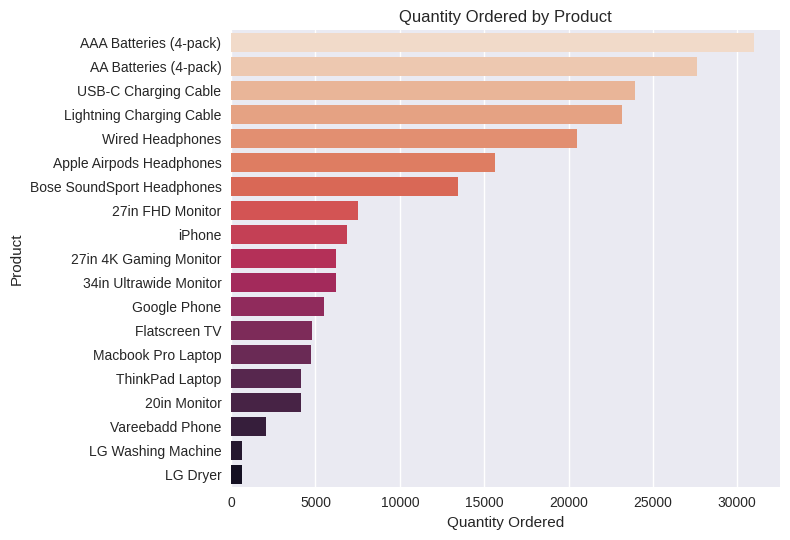

In [144]:
qty_prod = df.groupby('Product')['Quantity Ordered'].sum().sort_values(ascending=False).reset_index()
sns.barplot(y=qty_prod['Product'], x=qty_prod['Quantity Ordered'], data=qty_prod, palette='rocket_r')
plt.title('Quantity Ordered by Product')
plt.tight_layout()
plt.show()

While by the quantities sold, AAA Batteries and AA Batteries are the most frequently purchased products.

In [145]:
df['Quantity Ordered'].value_counts().sort_index().reset_index()

,Quantity Ordered,count
0,1.0,168291
1,2.0,13321
2,3.0,2920
3,4.0,806
4,5.0,236
5,6.0,80
6,7.0,24
7,8.0,5
8,9.0,3


The majority of transactions involve a single item. As the quantity increases, the number of transactions decreases sharply, indicating a strong right-skewed distribution.

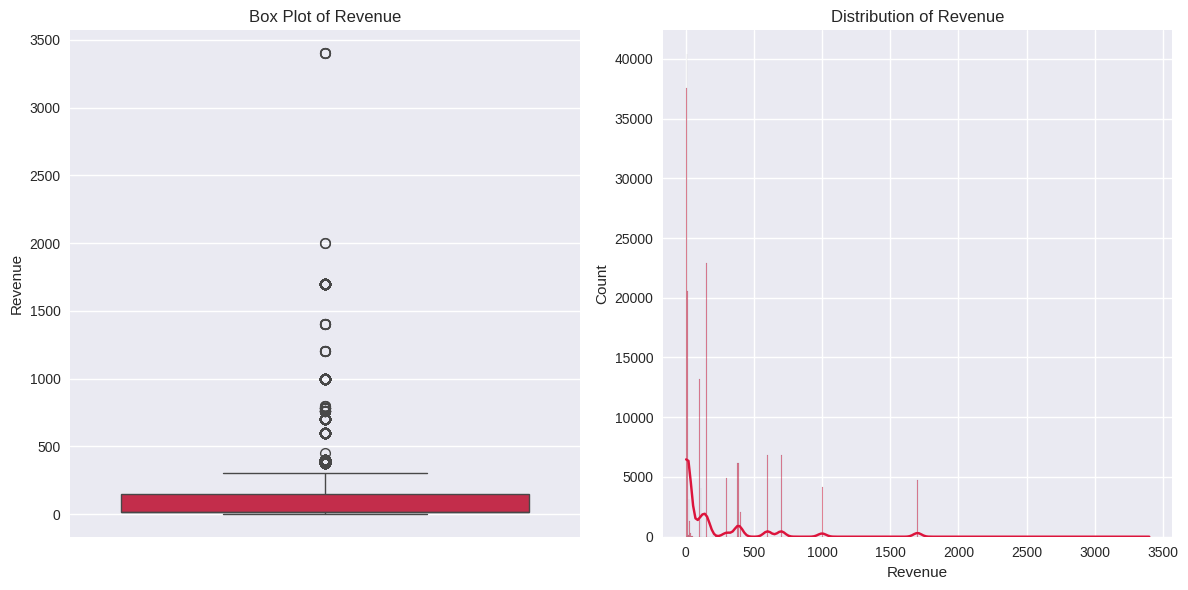

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(df['Revenue'].dropna(),ax=axes[0], color='crimson')
axes[0].set_title(f'Box Plot of Revenue')
sns.histplot(df['Revenue'].dropna(),ax=axes[1], color='crimson', kde=True)
axes[1].set_title(f'Distribution of Revenue')
plt.tight_layout()
plt.show()


Revenue continues to exhibit a highly skewed distribution, indicating that although customers most frequently purchase a single product per transaction, the products purchased generally have low unit prices.

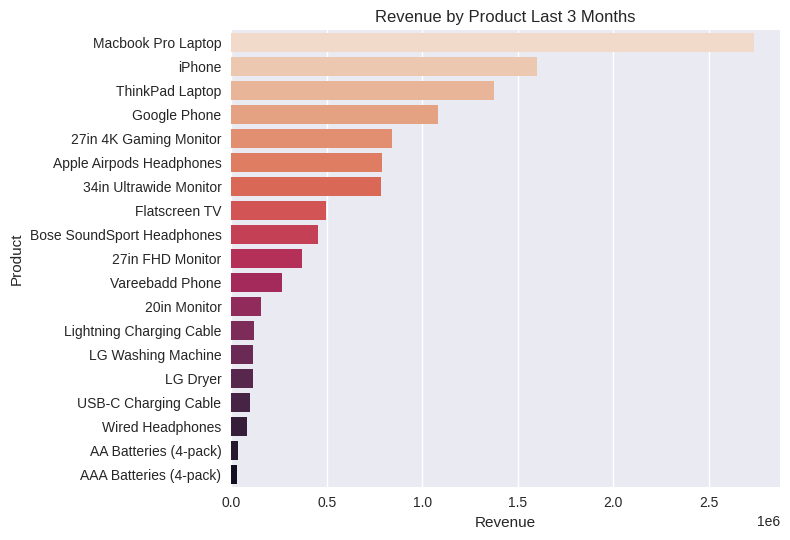

In [147]:
last_3_months = df[df.index >= '2019-10-01']

top_products_revenue = last_3_months.groupby('Product')['Revenue'].sum().sort_values(ascending=False).reset_index()
sns.barplot(y=top_products_revenue['Product'], x=top_products_revenue['Revenue'], data=top_products_revenue, palette='rocket_r')
plt.title('Revenue by Product Last 3 Months')
plt.tight_layout()
plt.show()


Based on total revenue over the last three months, the MacBook Pro Laptop is the top-performing product.

#Q5. Identify the top 5 cities with the highest number of orders and the 5 cities with the highest total and average spending.

In [148]:
df[['Street', 'City', 'State_Zip']] = df['Purchase Address'].str.split(',', expand=True)

df['City'] = df['City'].str.strip()
df['State_Zip'] = df['State_Zip'].str.strip()

df['State'] = df['State_Zip'].str.split(' ').str[0]


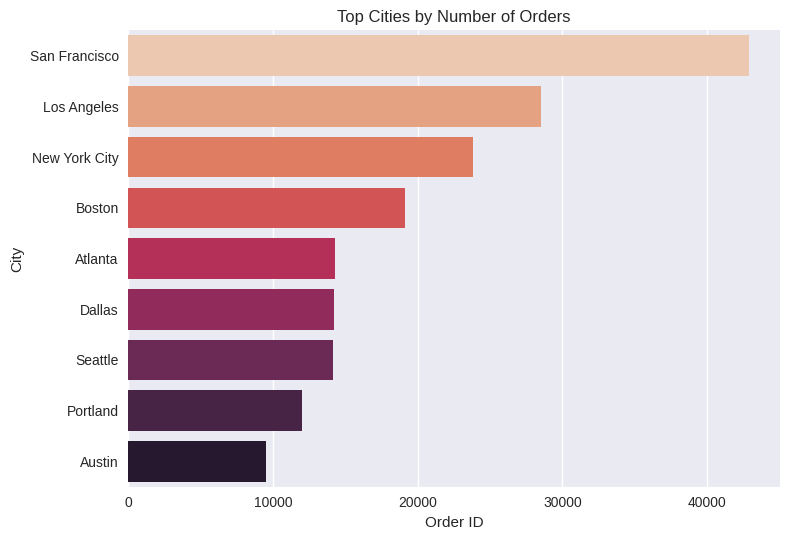

In [149]:
top_cities_orders = (
    df.groupby('City')['Order ID']
      .nunique()
      .sort_values(ascending=False).reset_index()
)

sns.barplot(y=top_cities_orders['City'], x=top_cities_orders['Order ID'], data=top_cities_orders, palette='rocket_r')
plt.title('Top Cities by Number of Orders')
plt.tight_layout()
plt.show()


San Francisco, Los Angeles, and New York City are the top three cities by number of orders.

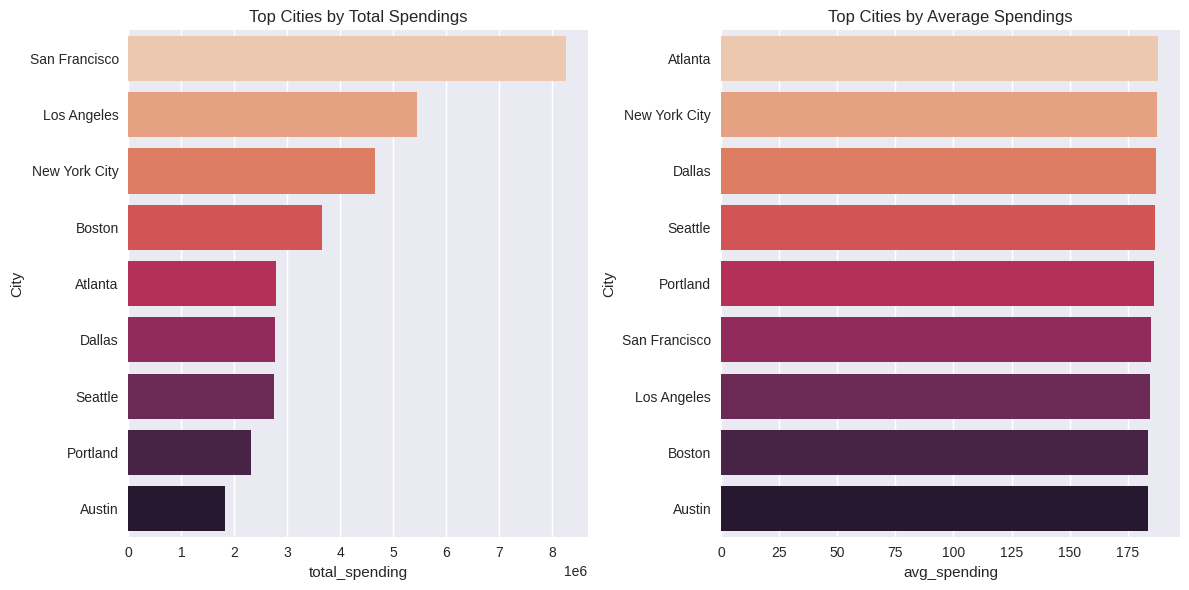

In [150]:
city_spending = (
    df.groupby('City')
      .agg(
          total_spending=('Revenue', 'sum'),
          avg_spending=('Revenue', 'mean')
      )
      .reset_index()
)

fig, axes =plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data=city_spending.sort_values('total_spending', ascending=False), y='City', x='total_spending', palette='rocket_r', ax=axes[0])
axes[0].set_title('Top Cities by Total Spendings')
sns.barplot(data=city_spending.sort_values('avg_spending', ascending=False), y='City', x='avg_spending', palette='rocket_r', ax=axes[1])
axes[1].set_title('Top Cities by Average Spendings')
plt.tight_layout()
plt.show()

For total spending, San Francisco leads among all cities. While Atlanta has the highest average spending per order, the average spending is fairly consistent across most cities.

#Trend & Pattern Analysis

Daily Aggregation

In [151]:
df_daily = (
    df
    .resample('D')
    .agg(
        total_transactions=('Order ID', 'nunique'),
        total_quantity=('Quantity Ordered', 'sum'),
        total_revenue=('Revenue', 'sum')
    )
)

df_daily = df_daily.sort_index()
df_daily.head()


,total_transactions,total_quantity,total_revenue
Order Date,,,
2019-01-01,287,343.0,65681.94
2019-01-02,308,367.0,70663.20
2019-01-03,286,330.0,47046.20
2019-01-04,282,329.0,62000.22
2019-01-05,301,355.0,46524.63


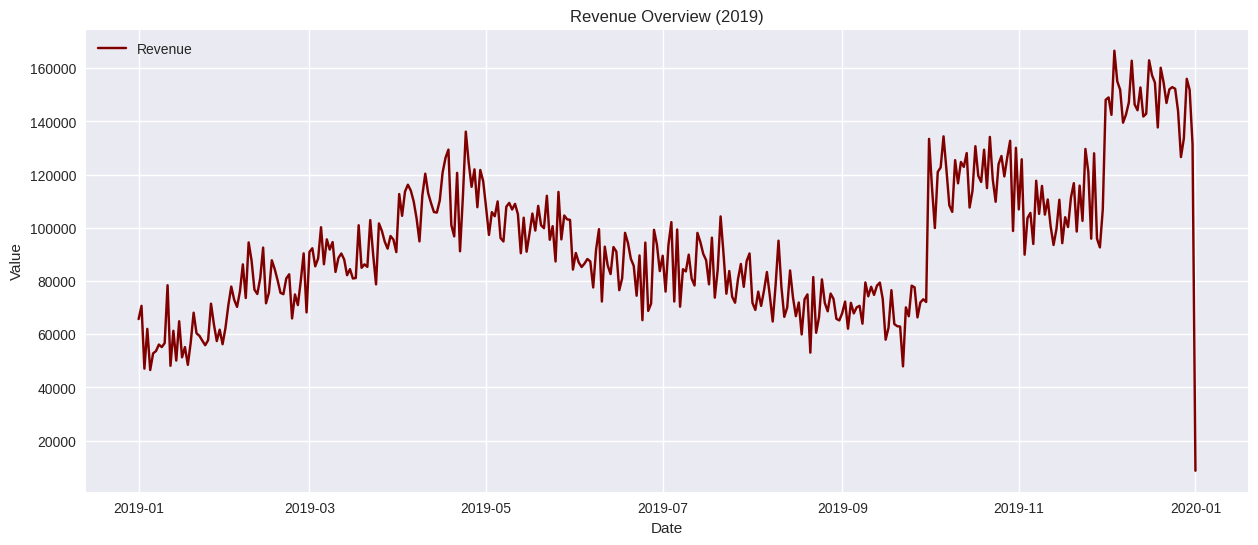

In [152]:
plt.figure(figsize=(15, 6))

plt.plot(df_daily.index, df_daily['total_revenue'], label='Revenue', color='maroon')

plt.title('Revenue Overview (2019)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [153]:
df[df.index.year > 2019].shape[0]


34

There are 34 transactions recorded in 2020. Since this analysis focuses exclusively on 2019 and the number of transactions in 2020 is extremely small compared to other months, these records were removed from the dataset.

In [154]:
df = df[df.index <= '2019-12-30']

In [155]:
df_daily = (
    df
    .resample('D')
    .agg(
        total_transactions=('Order ID', 'nunique'),
        total_quantity=('Quantity Ordered', 'sum'),
        total_revenue=('Revenue', 'sum')
    )
)

removing days with empty transactions

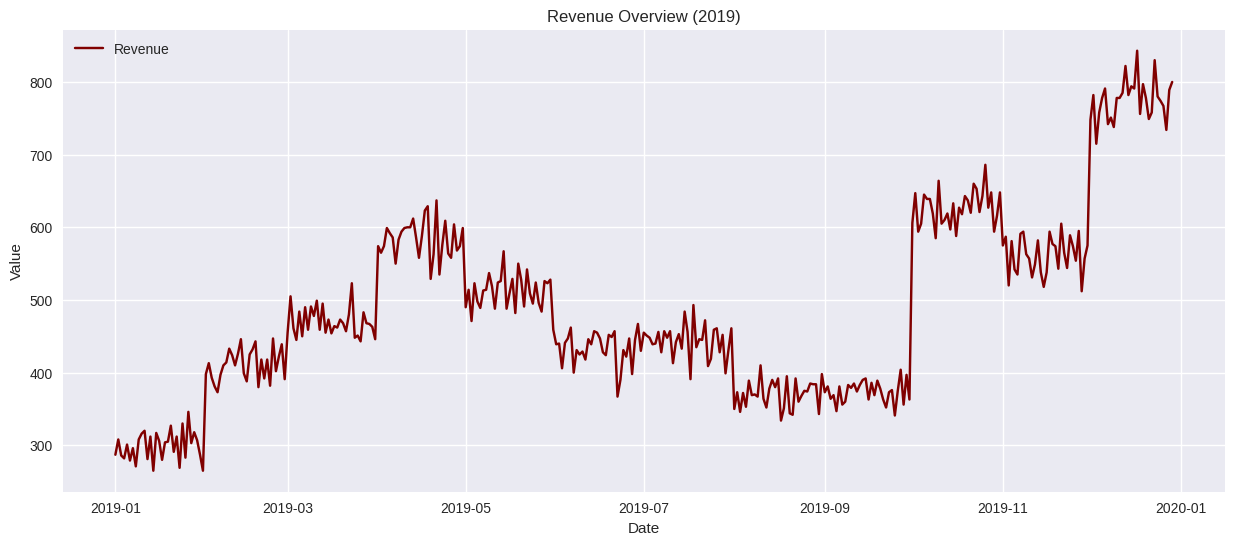

In [156]:
df_daily = df_daily.asfreq('D', fill_value=0)

plt.figure(figsize=(15, 6))

plt.plot(df_daily.index, df_daily['total_transactions'], label='Revenue', color='maroon')

plt.title('Revenue Overview (2019)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

Weekly, Monthly, and Seasonal(Quarter) aggregations

In [157]:
df_weekly = (
    df_daily
    .resample('W')
    .agg(
        total_transactions=('total_transactions', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        total_revenue=('total_revenue', 'sum')
    )
)
df_weekly['week'] = df_weekly.index.isocalendar().week.astype(int)

df_monthly = (
    df_daily
    .resample('M')
    .agg(
        total_transactions=('total_transactions', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        total_revenue=('total_revenue', 'sum')
    )
)
df_monthly['month'] = df_monthly.index.month

df_quarterly = (
    df_daily
    .resample('Q')
    .agg(
        total_transactions=('total_transactions', 'sum'),
        total_quantity=('total_quantity', 'sum'),
        total_revenue=('total_revenue', 'sum')
    )
)
df_quarterly['quarter'] = df_quarterly.index.quarter


Hourly and minute aggregations

In [158]:
df_hourly = (
    df
    .groupby('hour')
    .agg(
        total_transactions=('Order ID', 'nunique'),
        total_quantity=('Quantity Ordered', 'sum'),
        total_revenue=('Revenue', 'sum')
    )
    .reset_index()
)
df_minute = (
    df
    .groupby('minute')
    .agg(
        total_transactions=('Order ID', 'nunique'),
        total_quantity=('Quantity Ordered', 'sum'),
        total_revenue=('Revenue', 'sum')
    )
    .reset_index()
)



#Q2. Calculate the number of orders and GMV (Gross Merchandise Value) for the following time ranges: Daily Weekly Monthly

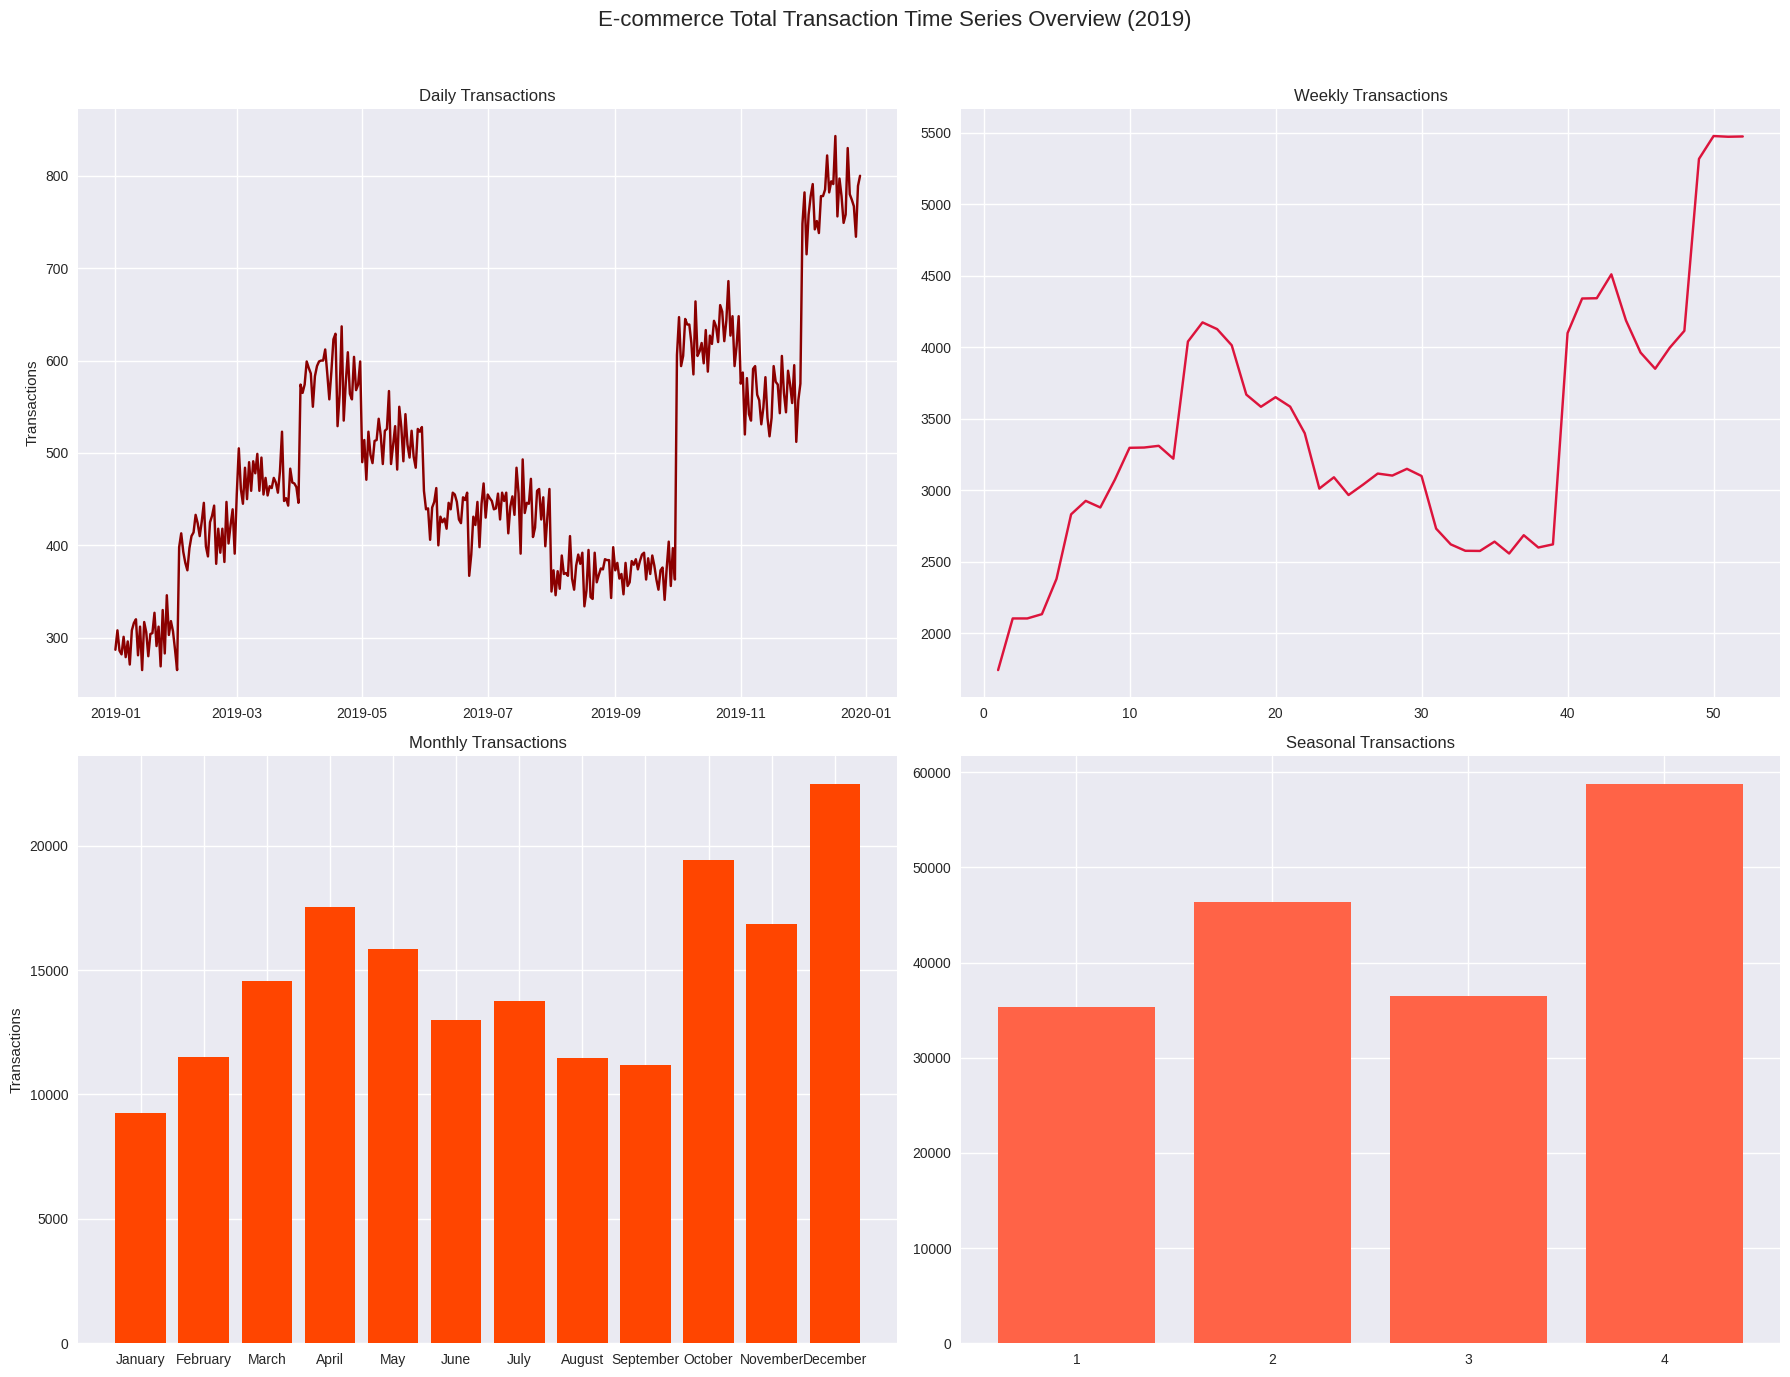

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('E-commerce Total Transaction Time Series Overview (2019)', fontsize=16)

#Daily Revenue
axes[0, 0].plot(df_daily.index, df_daily['total_transactions'], color='darkred')
axes[0, 0].set_title('Daily Transactions')
axes[0, 0].set_ylabel('Transactions')

#Weekly Revenue
axes[0, 1].plot(df_weekly['week'], df_weekly['total_transactions'], color='crimson')
axes[0, 1].set_title('Weekly Transactions')

#Monthly Revenue
axes[1, 0].bar(df_monthly['month'].astype(str), df_monthly['total_transactions'], color='orangered')
month_labels = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
axes[1, 0].set_xticklabels(month_labels)
axes[1, 0].set_ylabel('Transactions')
axes[1, 0].set_title('Monthly Transactions')

#Seasonal Revenue
axes[1, 1].bar(df_quarterly['quarter'].astype(str), df_quarterly['total_transactions'], color='tomato')
axes[1, 1].set_title('Seasonal Transactions')



plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


#Q6. The marketing team wants to know when sales reach their peak so they can design marketing strategies. Analyze the hours during which sales are most active (rush hours).

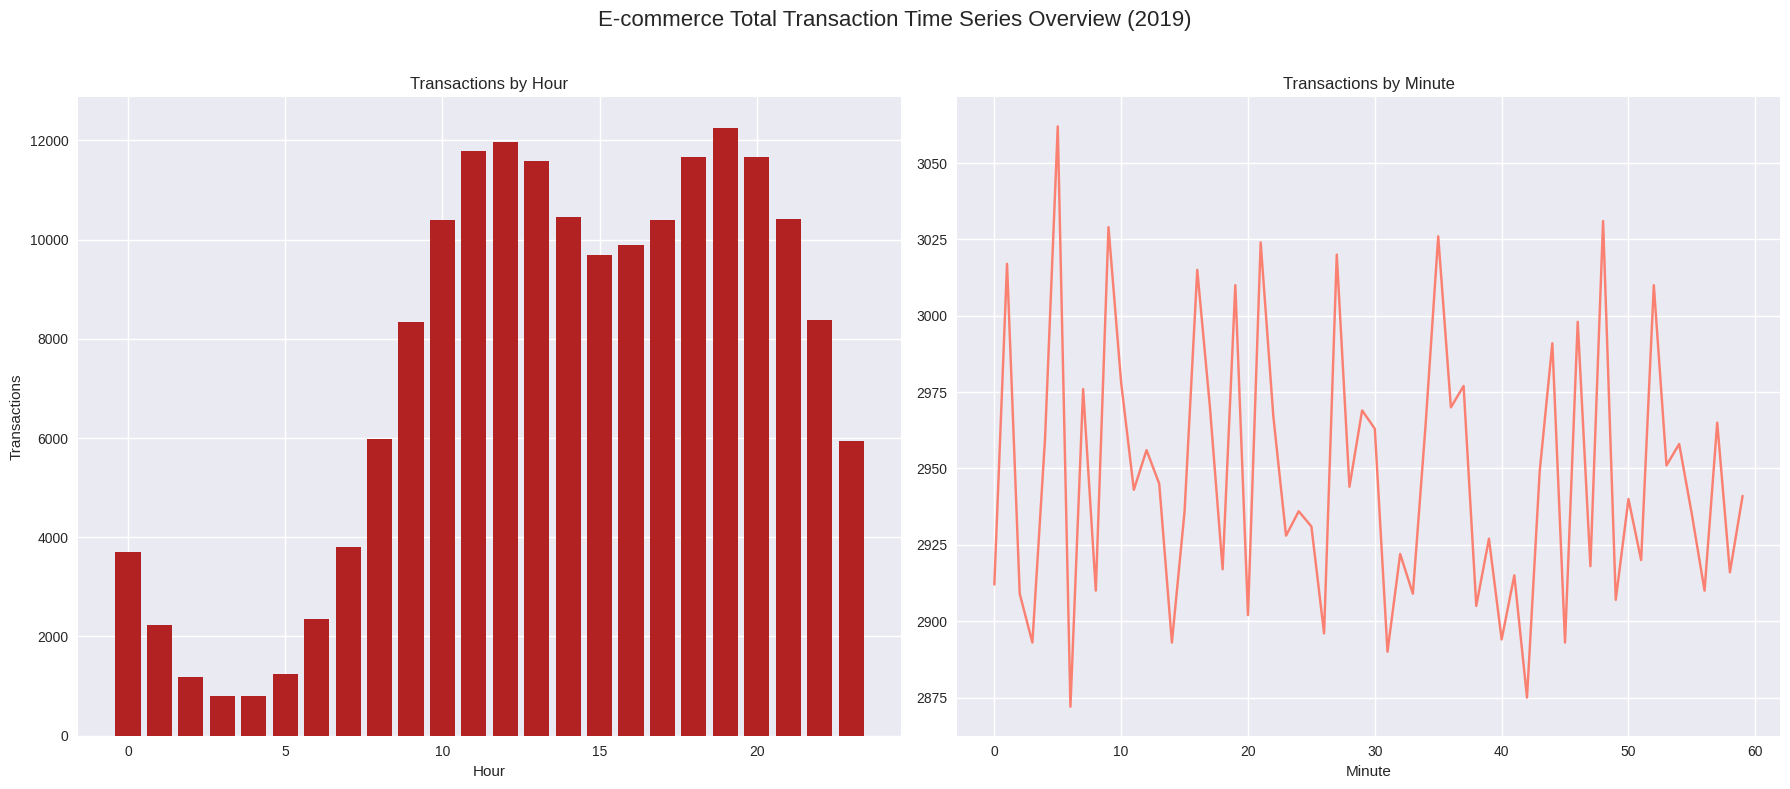

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('E-commerce Total Transaction Time Series Overview (2019)', fontsize=16)

#Hourly Transactions
axes[0].bar(df_hourly['hour'], df_hourly['total_transactions'], color='firebrick')
axes[0].set_title('Transactions by Hour')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Transactions')

#Minute-Level Transactions
axes[1].plot(df_minute['minute'], df_minute['total_transactions'],color='salmon')
axes[1].set_title('Transactions by Minute')
axes[1].set_xlabel('Minute')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


* Transactions peaks in the fourth quarter, with December contributing the largest share. It's likely driven by holiday season and promotions / year-end campaigns.
* Customer activity is highest around midday (12 PM) and in the evening (7 PM),suggesting peak shopping activity during lunchtime and evening hours.
* Transaction activity is strongest at the beginning of each hour, indicating that customers tend to place orders shortly after the hour changes.
* Revenue graphs are noisier than total transaction counts. However, this pattern still remains the same across all time resolutions except the minutely view, where revenue drops significantly between minutes 20-40 instead of showing the usual constant fluctuation.

#Splitting & Feature Engineering

In [161]:
#df_daily = df_daily[df_daily.index.month <= 9]
#run this to compare excluded quartile 4 results

More feature engineering

In [162]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

total_days = len(df_daily)
train_size = int(total_days * train_ratio)
val_size = int(total_days * val_ratio)

train_df = df_daily.iloc[:train_size].copy()
val_df = df_daily.iloc[train_size:train_size + val_size].copy()
test_df = df_daily.iloc[train_size + val_size:].copy()

y_train_ts = train_df['total_transactions']
y_val_ts = val_df['total_transactions']
y_test_ts = test_df['total_transactions']


In [163]:
df_daily['dayofweek'] = df_daily.index.dayofweek
df_daily['weekofyear'] = df_daily.index.isocalendar().week.astype(int)
df_daily['month'] = df_daily.index.month
df_daily['quarter'] = df_daily.index.quarter
df_daily['dayofyear'] = df_daily.index.dayofyear
df_daily['is_weekend'] = (df_daily['dayofweek'] >= 5).astype(int)

#Lag
df_daily['lag_1']  = df_daily['total_transactions'].shift(1)
df_daily['lag_7']  = df_daily['total_transactions'].shift(7)
df_daily['lag_14'] = df_daily['total_transactions'].shift(14)

#Rolling
df_daily['roll_mean_7']  = df_daily['total_transactions'].shift(1).rolling(7).mean()
df_daily['roll_mean_14'] = df_daily['total_transactions'].shift(1).rolling(14).mean()


#Cyclic
df_daily['dayofweek_sin'] = np.sin(2 * np.pi * df_daily['dayofweek']/7)
df_daily['dayofweek_cos'] = np.cos(2 * np.pi * df_daily['dayofweek']/7)
df_daily['dayofyear_sin'] = np.sin(2 * np.pi * df_daily['dayofyear']/365)
df_daily['dayofyear_cos'] = np.cos(2 * np.pi * df_daily['dayofyear']/365)
df_daily['month_sin'] = np.sin(2 * np.pi * df_daily['month']/12)
df_daily['month_cos'] = np.cos(2 * np.pi * df_daily['month']/12)

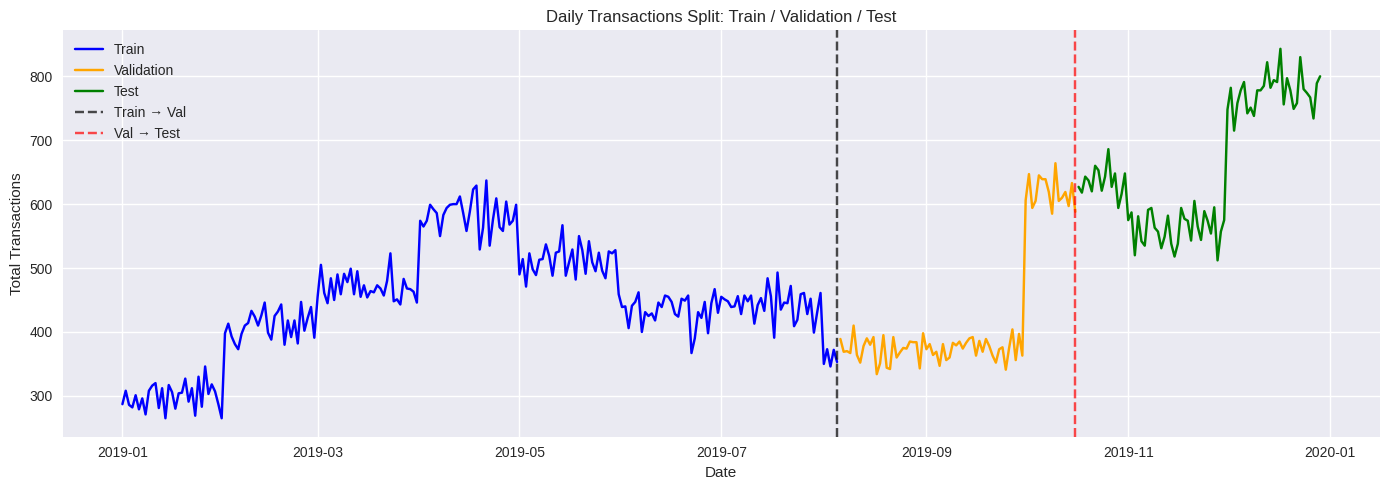

In [164]:
plt.figure(figsize=(14, 5))

plt.plot(train_df.index, y_train_ts, label='Train', color='blue')
plt.plot(val_df.index, y_val_ts, label='Validation', color='orange')
plt.plot(test_df.index, y_test_ts, label='Test', color='green')

plt.axvline(train_df.index[-1], color='black', linestyle='--', alpha=0.7, label='Train → Val')
plt.axvline(val_df.index[-1], color='red', linestyle='--', alpha=0.7, label='Val → Test')

plt.title('Daily Transactions Split: Train / Validation / Test')
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.legend()
plt.tight_layout()
plt.show()


#Forecasting Model & Evaluatiion

In [165]:
def evaluate_model(y_true, y_pred, model_name):
    y_pred = np.maximum(0, y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    y_true_safe = y_true.copy()
    y_true_safe[y_true_safe == 0] = 1e-9
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

    print(f"[{model_name}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return rmse, mae, mape

def plot_predictions(y_train, y_val, y_pred_val, model_name):
    plt.figure(figsize=(15, 5))
    plt.plot(y_train.index[-100:], y_train.tail(100), label='Train (Last 100d)', color='blue')
    plt.plot(y_val.index, y_val, label='Actual Val', color='black', alpha=0.6)
    plt.plot(y_val.index, y_pred_val, label=f'Pred {model_name}', linestyle='--', color='red')
    plt.title(f'Validation: {model_name}')
    plt.legend()
    plt.show()

[Naive Forecast] RMSE: 40.7368, MAE: 26.0417, MAPE: 5.98%


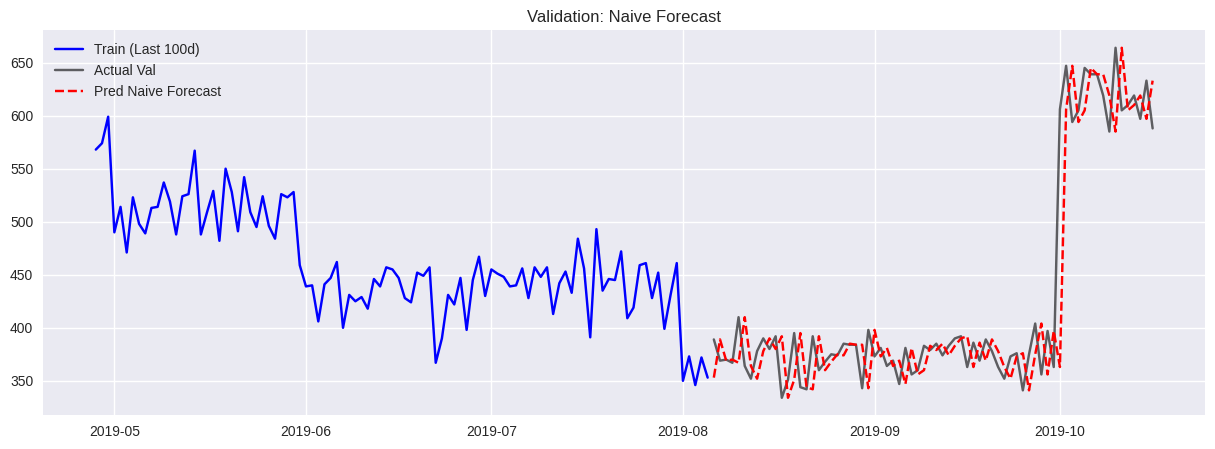

In [166]:
y_pred_naive = y_val_ts.shift(1)
y_pred_naive.iloc[0] = y_train_ts.iloc[-1]

evaluate_model(y_val_ts, y_pred_naive, "Naive Forecast")
plot_predictions(y_train_ts, y_val_ts, y_pred_naive, "Naive Forecast")

[Holt-Winters] RMSE: 178.3390, MAE: 122.7569, MAPE: 24.28%


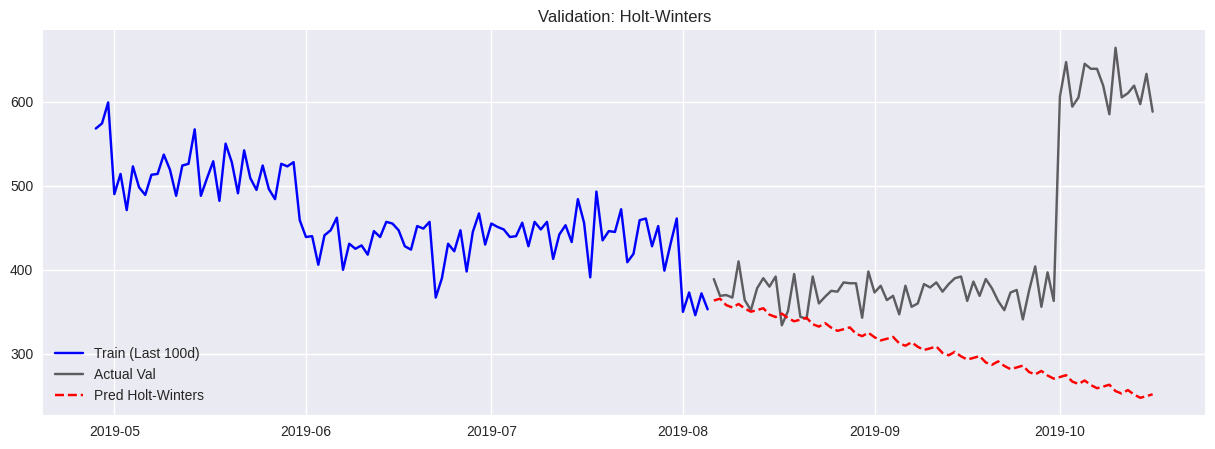

In [167]:
hw_model = ExponentialSmoothing(y_train_ts,trend='add',seasonal='add',seasonal_periods=7).fit()

y_pred_hw = hw_model.forecast(len(y_val_ts))

evaluate_model(y_val_ts, y_pred_hw, "Holt-Winters")
plot_predictions(y_train_ts, y_val_ts, y_pred_hw, "Holt-Winters")

[Prophet] RMSE: 109.1421, MAE: 87.7585, MAPE: 21.20%


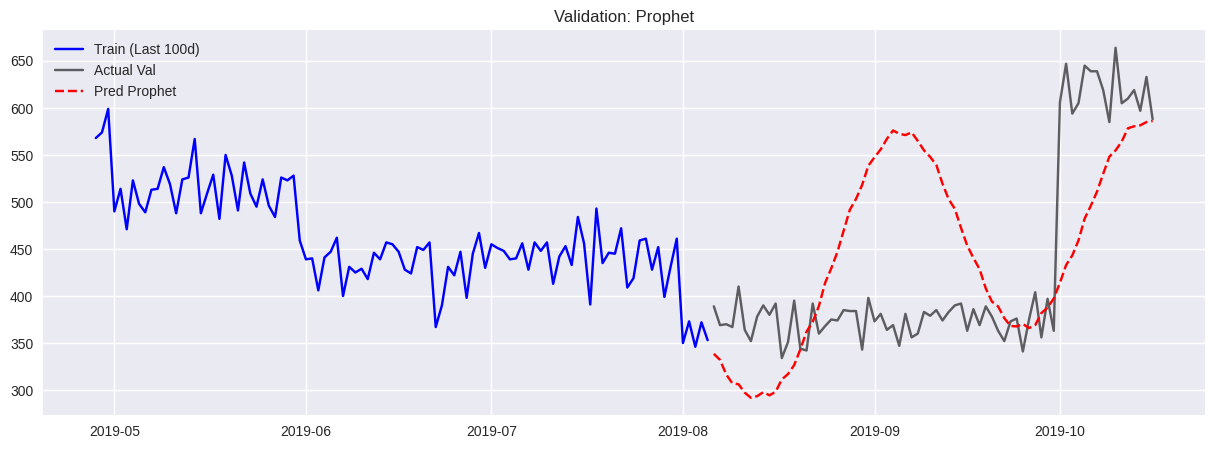

In [168]:
prophet_train = y_train_ts.reset_index()
prophet_train.columns = ['ds', 'y']

m = Prophet(weekly_seasonality=True,yearly_seasonality=True,daily_seasonality=True)

m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(y_val_ts), freq='D', include_history=False)
forecast = m.predict(future)

y_pred_prophet = forecast['yhat'].values
y_pred_prophet = np.maximum(0, y_pred_prophet)

evaluate_model(y_val_ts, y_pred_prophet, "Prophet")
plot_predictions(y_train_ts, y_val_ts, y_pred_prophet, "Prophet")


[SARIMA] RMSE: 133.3716, MAE: 79.5573, MAPE: 14.66%


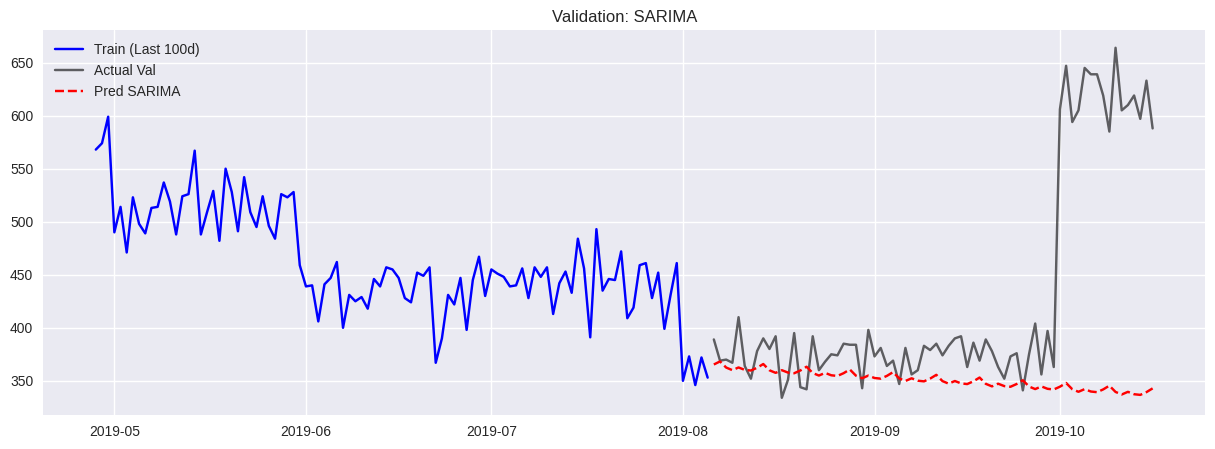

In [169]:
sarima_model = SARIMAX(
    y_train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit(disp=False)
y_pred_sarima = sarima_fit.forecast(steps=len(y_val_ts))
y_pred_sarima = np.maximum(0, y_pred_sarima)
evaluate_model(y_val_ts, y_pred_sarima, "SARIMA")
plot_predictions(y_train_ts, y_val_ts, y_pred_sarima, "SARIMA")


#Machine Learning Models

In [170]:
df_ml = df_daily.copy()

for lag in [1, 7, 14]:
    df_ml[f'lag_{lag}'] = df_ml['total_transactions'].shift(lag)

df_ml = df_ml.dropna()


In [171]:
train_size = int(len(df_ml) * 0.6)
val_size   = int(len(df_ml) * 0.2)

train_ml = df_ml.iloc[:train_size]
val_ml   = df_ml.iloc[train_size:train_size + val_size]
test_ml  = df_ml.iloc[train_size + val_size:]


In [172]:
features = ['lag_1', 'lag_7', 'lag_14']

X_train_ml = train_ml[features]
y_train_ml = train_ml['total_transactions']

X_val_ml = val_ml[features]
y_val_ml = val_ml['total_transactions']

X_test_ml = test_ml[features]
y_test_ml = test_ml['total_transactions']


[Random Forest] RMSE: 51.3941, MAE: 39.2093, MAPE: 8.77%


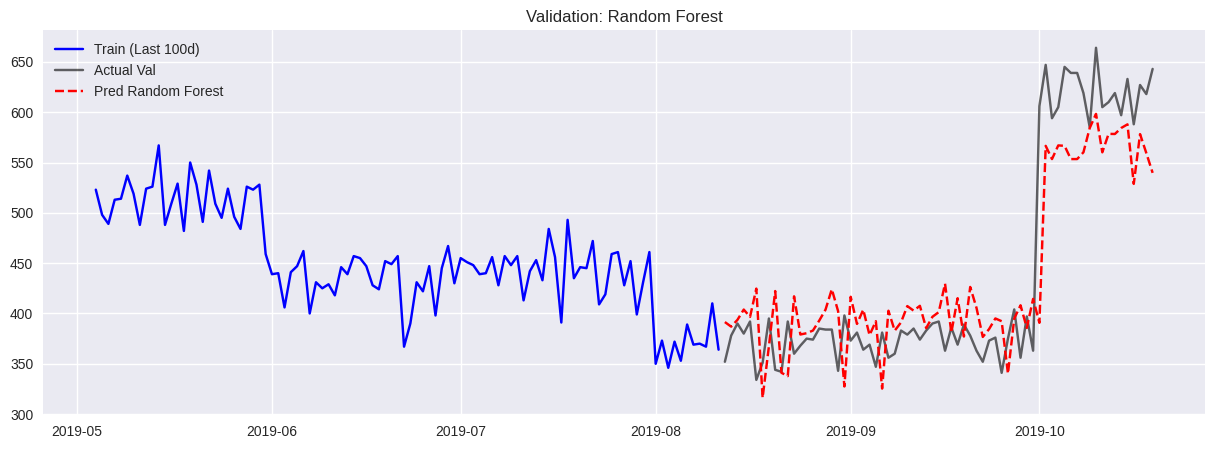

In [173]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train_ml, y_train_ml)
y_pred_rf = rf_model.predict(X_val_ml)

evaluate_model(y_val_ml, y_pred_rf, "Random Forest")

plot_predictions(
    y_train=y_train_ml,
    y_val=y_val_ml,
    y_pred_val=y_pred_rf,
    model_name="Random Forest"
)

[XGBoost] RMSE: 61.3106, MAE: 45.4705, MAPE: 9.82%


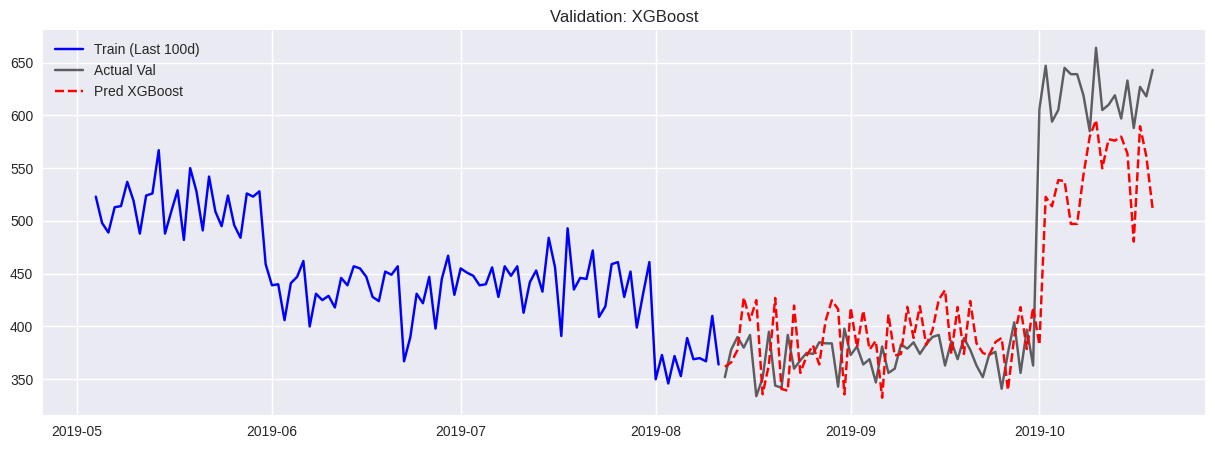

In [174]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_train_ml, y_train_ml)
y_pred_xgb = xgb_model.predict(X_val_ml)

evaluate_model(y_val_ml, y_pred_xgb, "XGBoost")
plot_predictions(y_train_ml, y_val_ml, y_pred_xgb, "XGBoost")


[Linear Regression] RMSE: 44.8573, MAE: 28.6871, MAPE: 6.18%


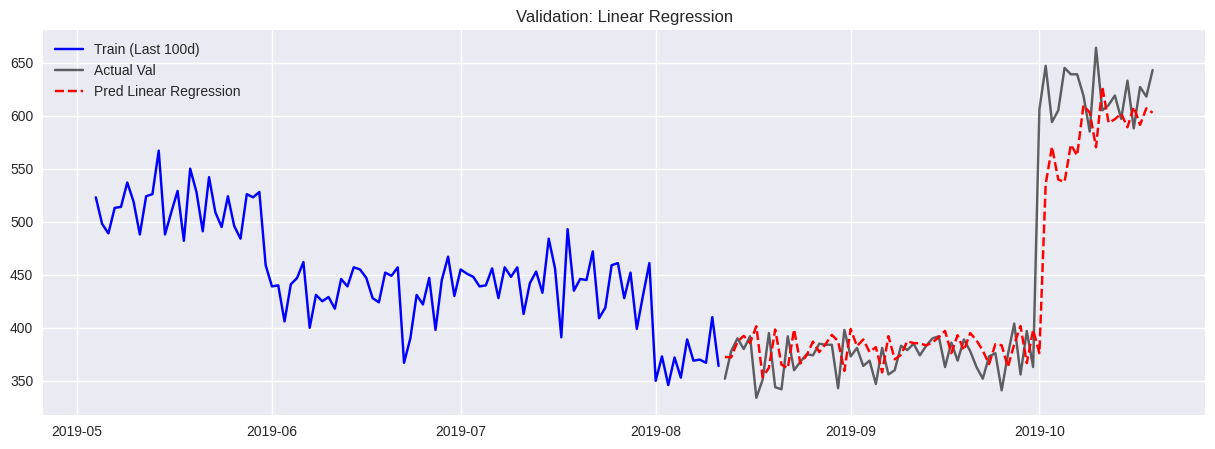

In [175]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_ml, y_train_ml)

y_pred_lr = lr_model.predict(X_val_ml)

evaluate_model(y_val_ml, y_pred_lr, "Linear Regression")
plot_predictions(y_train_ml, y_val_ml, y_pred_lr, "Linear Regression")


[Gradient Boosting] RMSE: 59.3611, MAE: 44.2835, MAPE: 9.68%


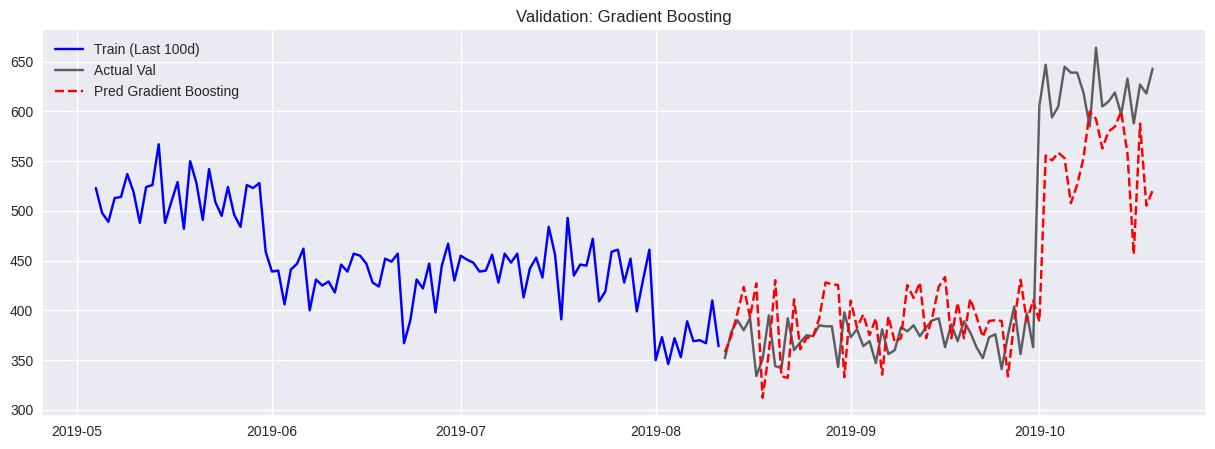

In [176]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr_model.fit(X_train_ml, y_train_ml)

y_pred_gbr = gbr_model.predict(X_val_ml)

evaluate_model(y_val_ml, y_pred_gbr, "Gradient Boosting")
plot_predictions(y_train_ml, y_val_ml, y_pred_gbr, "Gradient Boosting")


In [177]:
def plot_models_separately(y_train, y_val, predictions_dict, n_cols=2):
    n_models = len(predictions_dict)
    n_rows = int(np.ceil(n_models / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
    axes = axes.flatten()

    for ax, (model_name, y_pred) in zip(axes, predictions_dict.items()):
        y_pred = y_pred[:len(y_val)]

        # metric
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae  = mean_absolute_error(y_val, y_pred)

        y_safe = y_val.copy()
        y_safe[y_safe == 0] = 1e-9
        mape = np.mean(np.abs((y_val - y_pred) / y_safe)) * 100

        # plot train
        ax.plot(
            y_train.index[-100:],
            y_train.tail(100),
            label='Train (Last 100)',
            color='black'
        )

        # plot actual
        ax.plot(
            y_val.index,
            y_val.values,
            label='Actual',
            color='blue'
        )

        # plot prediction
        ax.plot(
            y_val.index,
            y_pred,
            linestyle='--',
            color='red',
            label='Prediction'
        )

        ax.set_title(
            f"{model_name}\nRMSE={rmse:.2f}, MAE={mae:.2f}, MAPE={mape:.2f}%"
        )
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)

    for i in range(len(predictions_dict), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


In [178]:
predictions_ts = {
    'Naive': y_pred_naive,
    'Holt-Winters': y_pred_hw,
    'Prophet': y_pred_prophet,
    'SARIMA': y_pred_sarima
}
predictions_ml = {
    'Linear Regression': y_pred_lr,
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gbr,
    'XGBoost': y_pred_xgb
}


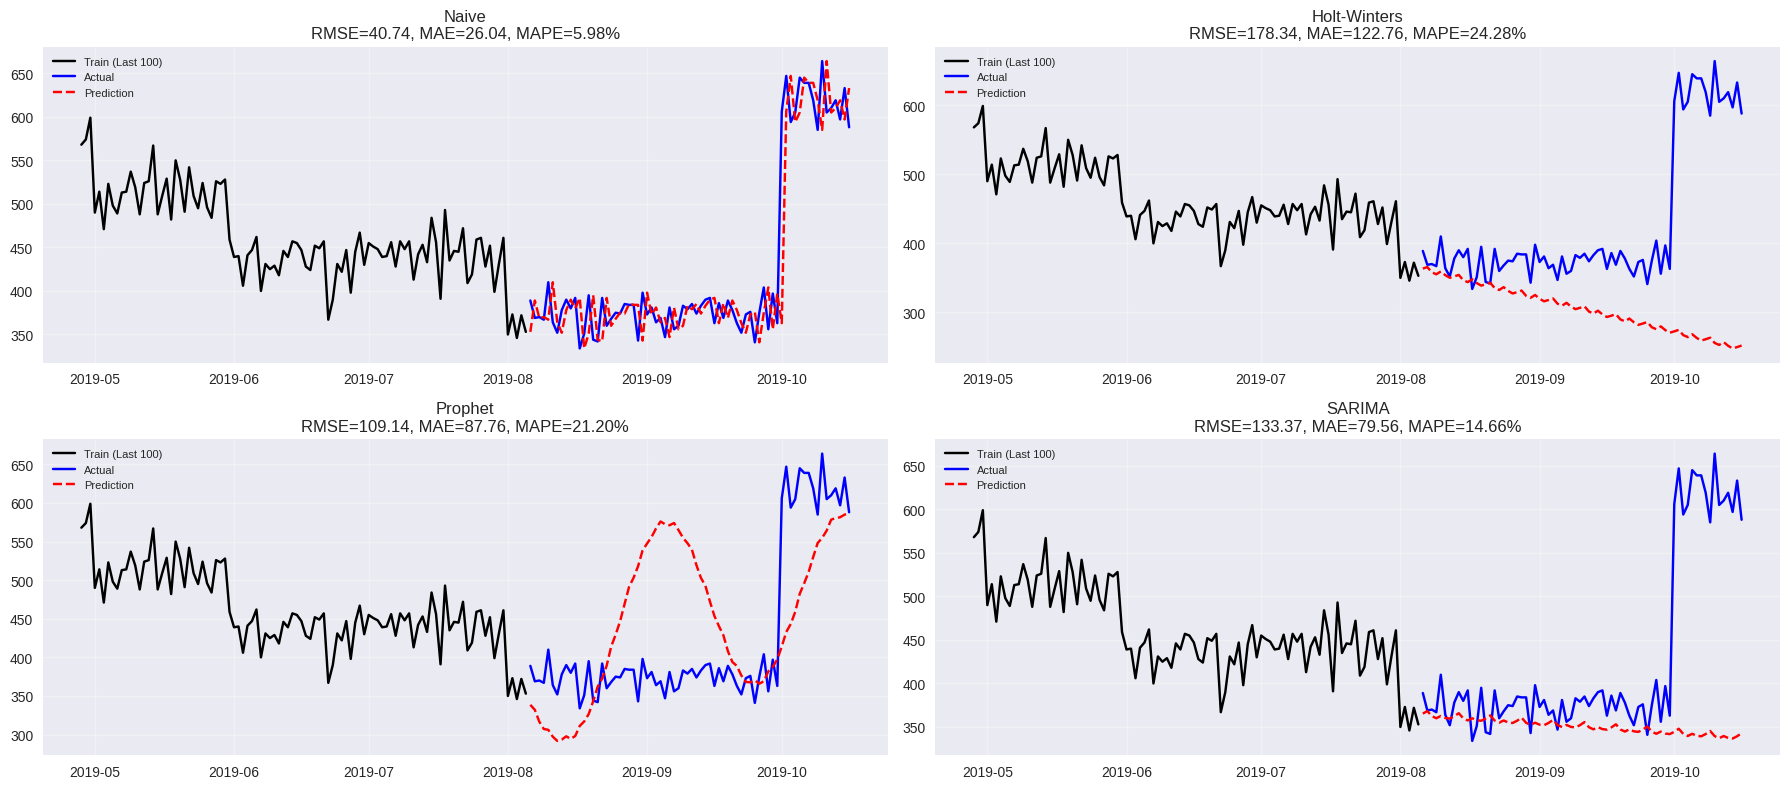

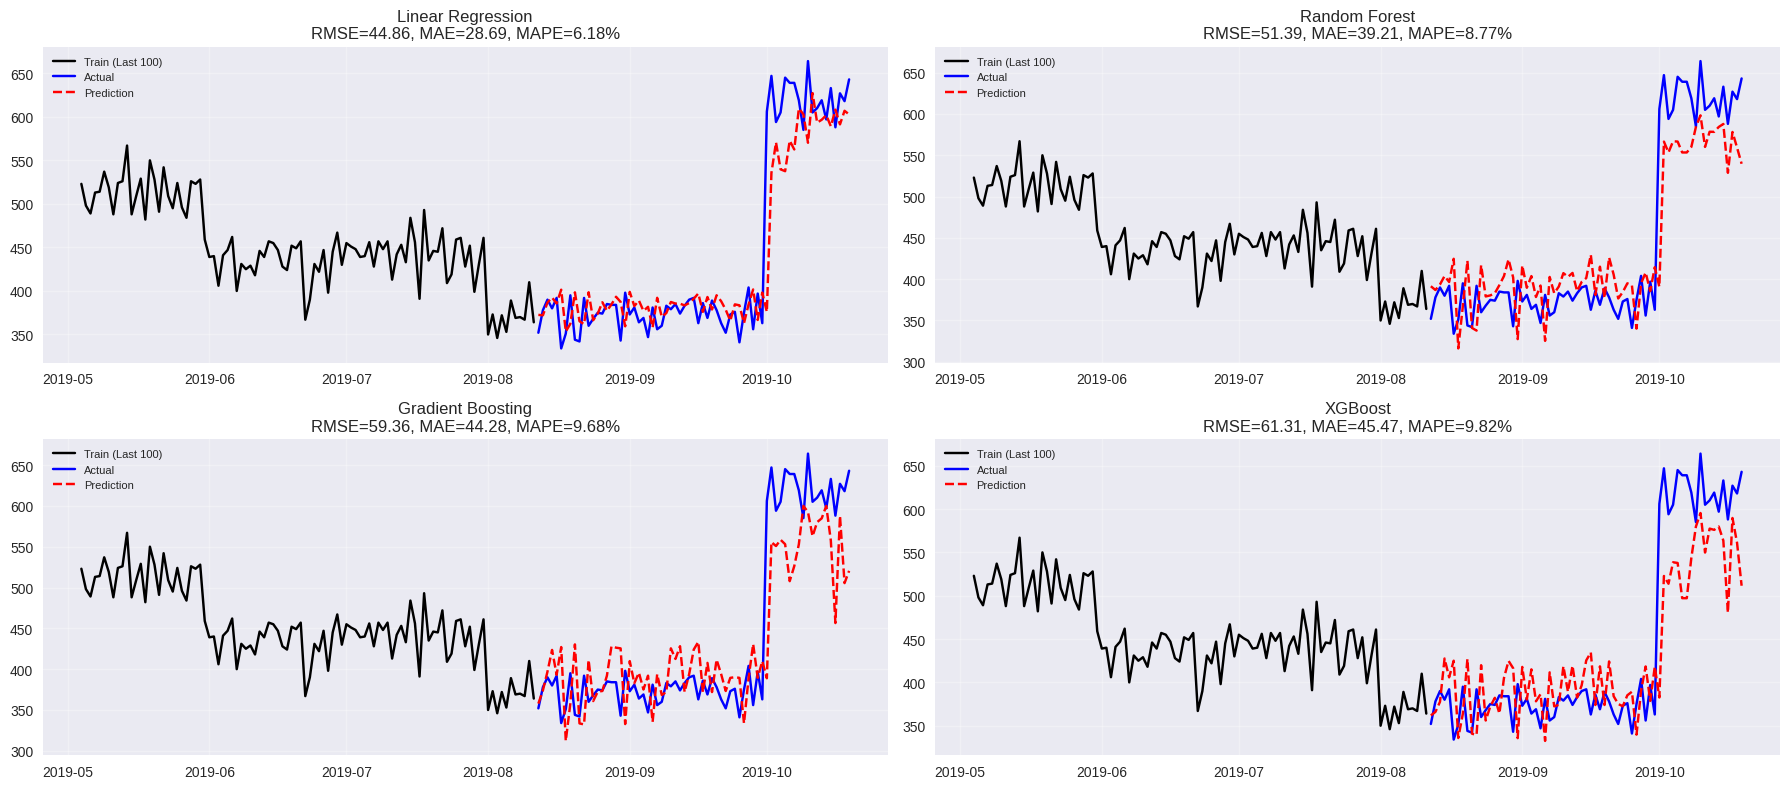

In [179]:
plot_models_separately(
    y_train_ts,
    y_val_ts,
    predictions_ts
)
plot_models_separately(
    y_train_ml,
    y_val_ml,
    predictions_ml
)


[FINAL Naive Test] RMSE: 42.4524, MAE: 33.0946, MAPE: 5.11%


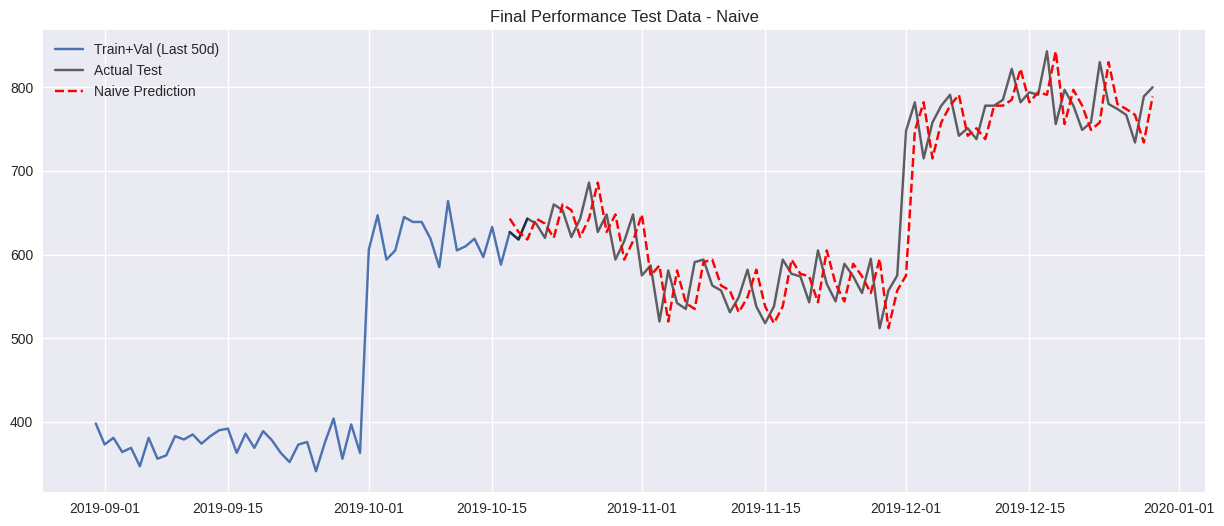

In [180]:
X_train_val = pd.concat([X_train_ml, X_val_ml])
y_train_val = pd.concat([y_train_ml, y_val_ml])

y_pred_test_naive = y_test_ts.shift(1)
y_pred_test_naive.iloc[0] = y_train_val.iloc[-1]

evaluate_model(y_test_ts, y_pred_test_naive, "FINAL Naive Test")

plt.figure(figsize=(15, 6))
plt.plot(y_train_val.index[-50:], y_train_val.tail(50), label='Train+Val (Last 50d)')
plt.plot(y_test_ts.index, y_test_ts, label='Actual Test', color='black', alpha=0.6)
plt.plot(y_test_ts.index, y_pred_test_naive, label='Naive Prediction', color='red', linestyle='--')
plt.title('Final Performance Test Data - Naive')
plt.legend()
plt.show()


[FINAL Linear Regression Test] RMSE: 45.0618, MAE: 35.1905, MAPE: 5.29%


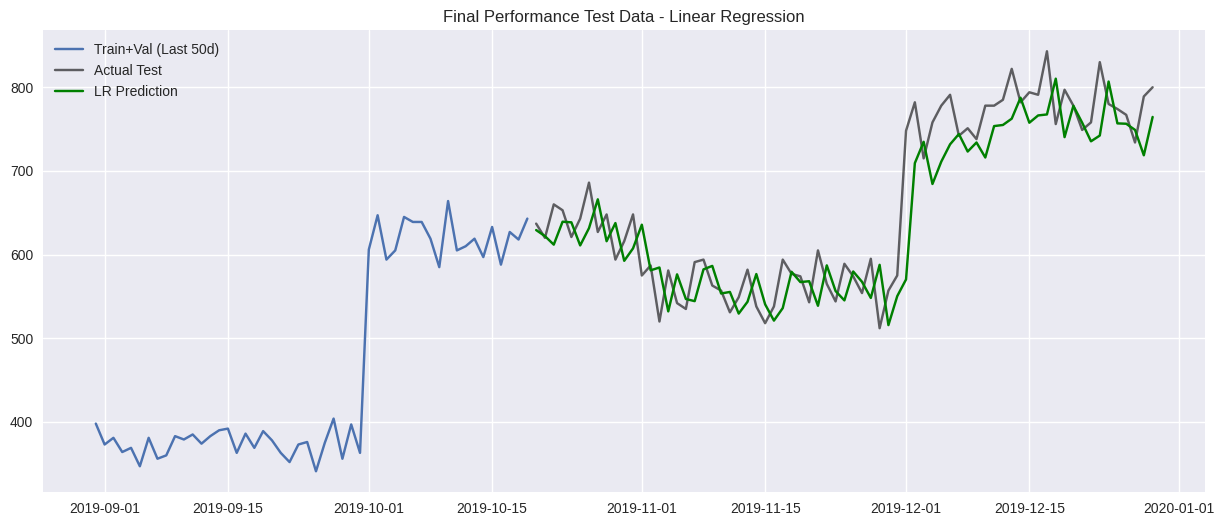

In [181]:
lr_final = LinearRegression()
lr_final.fit(X_train_val, y_train_val)

y_pred_test_lr = lr_final.predict(X_test_ml)

evaluate_model(y_test_ml, y_pred_test_lr, "FINAL Linear Regression Test")

plt.figure(figsize=(15, 6))
plt.plot(y_train_val.index[-50:], y_train_val.tail(50), label='Train+Val (Last 50d)')
plt.plot(y_test_ml.index, y_test_ml, label='Actual Test', color='black', alpha=0.6)
plt.plot(y_test_ml.index, y_pred_test_lr, label='LR Prediction', color='green')
plt.title('Final Performance Test Data - Linear Regression')
plt.legend()
plt.show()


#Forecasting Conclusion
Despite testing multiple advanced models (Holt-Winters, Prophet, SARIMA, and 4 different ML-based models), the simple naive model outperformed all others in terms of MAPE, MAE, and RMSE. This indicates that the data exhibits weak and unstable seasonality with abrupt level shifts, making complex models prone to overfitting. The second-best model was the ML-based Linear Regression, so the final test incorporated both approaches.

Over time, the data does not show a stable or repeating seasonal pattern. While transaction volumes tend to increase toward the end of the year, the timing and magnitude of these increases vary significantly and are often driven by irregular events such as holidays, promotions, or special campaigns. These spikes occur inconsistently across weeks and months, making the seasonal behavior unstable. As a result, models that rely on fixed or smooth seasonal structures struggle to generalize, whereas the naive model performs well by adapting to short-term day-to-day changes.